Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to run MCMC with ease. In the following case studies we will be applying this to the biological domain.

Case Study 1: Growth Only

First you need to read in the data. Pandas is the defacto package for this task so we'll start there. You will read in the data as seen below and you will grab the values from the columns as shown below.

In [1]:
# Step 1: Load and view data
import pandas as pd
data = pd.read_csv("../../case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values
#plt.scatter(time, obs)

Now, here is the first thing we need to do. Wetup the ODE that we are going to have try to adapt to the data. In this first example we are going to setup a logistic ODE. We will do a little hand waving over some things that PYMC does behind the scenes but that is okay! We will cover everything you truly need to understand to make proper use of the software. 

$$
\frac{dy}{dt} = \mu y
$$

$$
y(t) = y_0 e^{\mu t}
$$

The ODE above contains $\mu$ (mum), a growth rate which is set ahead of time by 'params'. y[0] is the current state value for the interation the markov chain is on. The function returned is expected to be in the form of a list, or list of lists. This will become even more clear later, so for now just trust :)

In [2]:
# This is how you declare a function in python. Python is incredibly flexible.
def ode(y, t, params):
    mum = params[0]
    return [mum * y[0]]

This is our first use of pymc. This is the creation of the model itself. It takes into account the function, time points, states, theta (amount of 'tunable' parameters), and t0 which is the time step to start at it should always be 0.

(in our case this is 1, this will increase with the amount of states we are tracking, this too will become more clear in the future, so again just trust! ) 

func: the ODE function we created earlier

times: time steps given from the data

n_states: categories of data being analyzed

n_theta: amount of variables being tested by the chains

t0: initial time step

In [3]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=1,
    t0=0
)

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Here we are going to include our additional parameters necessary for the model to run. We are including numpy to assist in our model insertion. 

Here's a brief explination of priors. A prior is an inital prediction of where you believe values will fall. It is not an end all be all since the model can/will drift away, it is just an inital prediction. It can also reign in values to keep them from getting too far off. There are all kinds of priors as we will see in the future.

Let's explain out choices here. 

<img src="priors_c1p1.png" width="300"/>




For mu, we use a truncated noraml distribution. This gives us to freedom to customize a couple things. It is up to you and/or domain knowledge to set these. You can change its center, how wide it is, and where the cutoffs are on each side. 

For N0, we chose a lognormal distribution. on a basic level it can be thought of a normalesque distribution that is strictly positive. 

For sigma, we chose a half normal distribution. Error can only be a positive value and should in thoery be low so we chose this prior.

Choosing priors isn't an easy thing and always requires solid justification. Whether it be through experimentation or domain knowledge, they should always be justified.

In [4]:
import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum])
    pm.Normal("Y_obs", mu=pm.math.log(y_hat[:, 0]), sigma=sigma, observed=np.log(obs))

The follwing code block will have the line you would use to run this live. However, to save time, it has already been run on our end and save into a .nc file. We will just read the file in and move on.

draws: the number of posterior samples to be calculated

tune: It's a PYMC under the hood warm up period. The short answer is the more complex your model is, the more tuning steps you'll want. 500-2000 is a good range to play with.

chains: The amound of chains you want running in parrallel with eachother. 

return_inferencedata: returns the trace variable as an arviz inferencedata object which makes for easier plotting and analysis

We use arviz to write to/from .nc files.

In [5]:
'''
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=True)
'''
import arviz as az
trace = az.from_netcdf("case_study_1_p1_trace.nc")

This next section is subject to change. We have created a plotting function and I will write something more digestable here in time.

Sampling: [N0, Y_obs, mum, sigma]


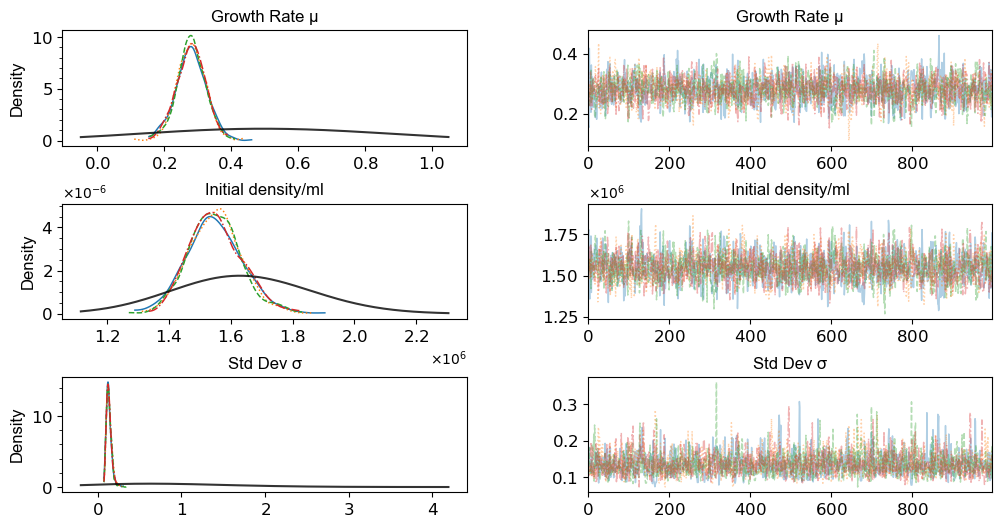

array([[<Axes: title={'center': 'Growth Rate μ'}, ylabel='Density'>,
        <Axes: title={'center': 'Growth Rate μ'}>],
       [<Axes: title={'center': 'Initial density/ml'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial density/ml'}>],
       [<Axes: title={'center': 'Std Dev σ'}, ylabel='Density'>,
        <Axes: title={'center': 'Std Dev σ'}>]], dtype=object)

In [6]:
import sys
from pathlib import Path

# get project root by walking up 2 levels from this notebook's directory
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

from utils.plot_utils_v2 import plot_trace
plot_trace(
    trace=trace,
    model=model,
    var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
    var_order=['mum','N0','sigma'],
    fontname='Arial',
    fontsize=12,
    num_prior_samples=2000,
    save_path='../../case_study_1/python/figures/normal_growth_chains.png'
)

Case Study 1: Growth and Death

Now we'll move onto a more complex model. This one accounts for both growth and death. We are using the dame dataset with only time steps and cell counts. This is what makes these models so enticing. You can design the model expressive about the data. 

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

$$
y(t) = y_0 e^{(\mu - \delta)t}
$$


In [7]:
def ode(y, t, params):
    mum,delta = params[0],params[1]
    return [(mum-delta) * y[0]]

Update Theta!

n_theta: Number of variables being explored. Now we have growth and death its 2. 

In [8]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=2,
    t0=0
)

Initializing these priors will follow the same logic as before.

In [9]:
import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum, delta])
    pm.Normal("Y_obs", mu=pm.math.log(y_hat[:, 0]), sigma=sigma, observed=np.log(obs))

Same as before!

In [10]:
'''
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=True)
'''
import arviz as az
trace = az.from_netcdf("case_study_1_p2_trace.nc")

Repeat section of text I'm not yet super sure what to do with.

Sampling: [N0, Y_obs, delta, mum, sigma]


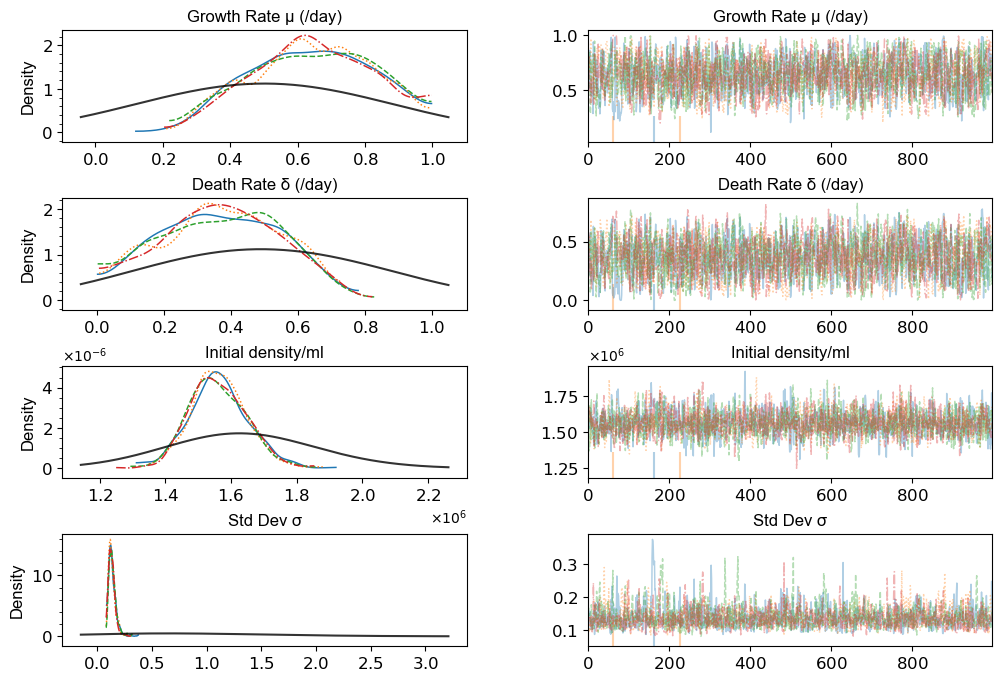

array([[<Axes: title={'center': 'Growth Rate μ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Growth Rate μ (/day)'}>],
       [<Axes: title={'center': 'Death Rate δ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Death Rate δ (/day)'}>],
       [<Axes: title={'center': 'Initial density/ml'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial density/ml'}>],
       [<Axes: title={'center': 'Std Dev σ'}, ylabel='Density'>,
        <Axes: title={'center': 'Std Dev σ'}>]], dtype=object)

In [11]:
import sys
from pathlib import Path

# get project root by walking up 2 levels from this notebook's directory
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

from utils.plot_utils_v2 import plot_trace
plot_trace(
    trace=trace,
    model=model,
    var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ (/day)', 'delta': 'Death Rate δ (/day)','sigma': 'Std Dev σ'},
    var_order=['mum','delta','N0','sigma'],
    fontname='Arial',
    fontsize=12,
    num_prior_samples=1000,
    save_path='../../case_study_1/python/figures/normal_growthdeath_chains.png'
)

The End